# Implementation of Knowledge Based SDDC LCM.

### Import Library

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import math
import re
import time
from time import strftime
from utils import util


### configure spark variables 

In [2]:
__author__ = 'raviranjan'

#from pyspark import SparkConf, SparkContext
#from pyspark.context import SparkContext
#from pyspark.sql.context import SQLContext
#from pyspark.sql.session import SparkSession
   
#sc = SparkContext()
#sqlContext = SQLContext(sc)
#spark = SparkSession(sc)

### Define variables contants

In [8]:
LOG_DIR = "logs"
TIME_STAMP_PATTERN = "^(2[0-3]|[01]?[0-9]):(0[1-9]{1}|[1-5]{1}[0-9]):(0[1-9]{1}|[1-5]{1}[0-9])$"
HOST_PATTERN = r'(^\S+\.[\S+\.]+\S+)\s'
LOGGER_FILE_PATTERN = r'(^\S+\.[\S+\.]+\S+)\s'
ERROR_PATTERN = 'ERROR:'
INFO_PATTERN = 'INFO:'
DEBUG_PATTERN = 'DEBUG:'
time_stamp_pattern = r'\[(\d{2}/\w{3}/\d{4}:\d{2}:\d{2}:\d{2} -\d{4})]'
host_pattern = r'(^\S+\.[\S+\.]+\S+)\s'
logger_file_pattern = r'(^\S+\.[\S+\.]+\S+)\s'
has_error_pattern = r''
excel_file_path = "data/excel_data_1.xlsx"



# Create a util class

In [18]:
import re
import os
import time
from time import strftime


def export_to_file(dict_with_list_values=None, export_file_path=None, export_folder=None):
    """
    dict_with_list_values = {'Brand': ['Honda Civic','Toyota Corolla','Ford Focus','Audi A4'],
        'Price': [32000,35000,37000,45000]
        }
    :param export_folder:
    :param dict_with_list_values:
    :param create_dict_from_list:
    :param column_name
    :return:
    """
    if not export_file_path:
        time_now = str(strftime("%Y-%m-%d %H-%M-%S", time.localtime()))
        export_file_path = export_folder + "/" + time_now + ".xlsx"
    columns = dict_with_list_values.keys()
    print('Exporting columns %s to %s' % (columns, export_file_path))
    import pandas as pd
    df = pd.DataFrame(dict_with_list_values, columns=columns)
    df.to_excel(export_file_path, index=False, header=True)
    print(export_file_path)
    return export_file_path


def get_data_to_export(log_files, column_names=['line', 'info', 'error', 'debug', 'warn', 'exception', 'filename']):
    excel_export_data = {
    }
    for column_name in column_names:
        excel_export_data[column_name] = []
    print("Define column %s" % excel_export_data)
    for log_file in log_files:
        with open(log_file) as f:
            for line in f:
                one_row_values = {} # store one row value with key as column name and its value
                for column_name in column_names:
                    column_name = column_name.lower()
                    line = line.lower().strip()
                    if column_name in line:
                        column_value = 1
                    else:
                        column_value = 0
                    if column_name == "line":
                        one_row_values[column_name] = line
                    elif column_name == "filename":
                        one_row_values[column_name] = log_file.split('/')[-1]
                    else:
                        one_row_values[column_name] = column_value
                for column_name in one_row_values:
                    # append the list value
                    existing_one_column_values = excel_export_data[column_name]
                    existing_one_column_values.append(one_row_values[column_name])
                    excel_export_data[column_name] = existing_one_column_values

    # print("%s" % excel_export_data)
    return excel_export_data


def get_log_files(log_dir):
    log_files = []
    for root, dir_, files in os.walk(log_dir):
        for sub_dir in dir_:
            sub_dir_path = os.path.join(root, sub_dir)
            # print("sub_dir: %s" % sub_dir_path)
            # os.system('ls %s' % sub_dir_path)
        for f in files:
            f_path = os.path.join(root, f)
            if ".log" in f_path:
                log_files.append(f_path)
    print("%s" % (log_files))
    return log_files


def findall_(log_file, regex):
    matched_lines = []
    with open(log_file) as f:
        # lines = f.readlines()
        for line in f:
            found = re.findall(regex, line)
            if found:
                matched_lines.append(line)
        print(matched_lines)
    return matched_lines


def search_re(line, pattern=None):
    # Python program to illustrate
    # Matching regex objects
    match = re.match(pattern, line)
    if not match:
        regex_com = re.compile(pattern)
        match = regex_com.search(line)
        if match:
            value = match.group()
            print('found using re.compile: %s' % value)
            return value
        else:
            print('%s not Found using re.compile also:' % pattern)
            return ''
    else:
        value = match.group()
        print('Found using re.match: %s' % value)
        return value


def finditer_(log_file_path, regex, read_line=True, re_parse=False):
    """
    regex = '(<property name="(.*?)">(.*?)<\/property>)'
    :param log_file_path:
    :param regex:
    :param read_line:
    :param re_parse:
    :return:
    """
    with open(log_file_path, "r") as f:
        match_list = []
        if read_line:
            for line in f:
                for match in re.finditer(regex, line, re.S):
                    match_text = match.group()
                    print(match_text)
                    print(line)
                    match_list.append(match_text)
        else:
            data = f.read()
            for match in re.finditer(regex, data, re.S):
                match_text = match.group()
                match_list.append(match_text)
    f.close()
    if re_parse:
        match_list = finditer_again(match_list, regex)
    print(match_list)
    return match_list


def finditer_again(parsed_data, regex):
    data_string = ''.join(parsed_data)
    match_list = []
    for match in re.finditer(regex, data_string, re.S):
        match_text = match.group()
        match_list.append(match_text)
    print(match_list)
    return match_list


### Get log files

In [19]:
log_files = get_log_files(log_dir=LOG_DIR)

['logs/HealthApp/HealthApp.log', 'logs/OpenStack/OpenStack.log', 'logs/OpenSSH/SSH.log', 'logs/Proxifier/Proxifier.log', 'logs/HPC/HPC.log', 'logs/Zookeeper/Zookeeper.log', 'logs/Mac/Mac.log', 'logs/Hadoop/Hadoop.log', 'logs/Linux/Linux.log', 'logs/Andriod/Andriod_2k.log', 'logs/HDFS/HDFS.log', 'logs/BGL/BGL.log', 'logs/Windows/Windows.log', 'logs/Apache/Apache.log', 'logs/Thunderbird/Thunderbird.log', 'logs/Spark/Spark.log']


### Get Data from logs and export to Excel 

In [20]:
excel_export_data = get_data_to_export(log_files=log_files, column_names=['line', 'info', 'error', 'debug', 'warn', 'exception', 'filename'])

export_to_file(dict_with_list_values=excel_export_data, export_file_path=excel_file_path)

Define column {'line': [], 'info': [], 'error': [], 'debug': [], 'warn': [], 'exception': [], 'filename': []}
Exporting columns dict_keys(['line', 'info', 'error', 'debug', 'warn', 'exception', 'filename']) to data/excel_data_1.xlsx
data/excel_data_1.xlsx


'data/excel_data_1.xlsx'

# Analyzing Data

In [21]:
print(excel_file_path)
excel_data = pd.read_excel(excel_file_path)
excel_data.head(5)

data/excel_data_1.xlsx


,line,info,error,debug,warn,exception,filename
0,20171223-22:15:29:606|step_lsc|30002312|onstan...,0,0,0,0,0,HealthApp.log
1,20171223-22:15:29:615|step_lsc|30002312|onexte...,0,0,0,0,0,HealthApp.log
2,20171223-22:15:29:633|step_standreportreceiver...,0,0,0,0,0,HealthApp.log
3,20171223-22:15:29:635|step_lsc|30002312|proces...,0,0,0,0,0,HealthApp.log
4,20171223-22:15:29:635|step_standstepcounter|30...,0,0,0,0,0,HealthApp.log


### Draw few plot


In [22]:
print((excel_data.info()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32000 entries, 0 to 31999
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   line       32000 non-null  object
 1   info       32000 non-null  int64 
 2   error      32000 non-null  int64 
 3   debug      32000 non-null  int64 
 4   warn       32000 non-null  int64 
 5   exception  32000 non-null  int64 
 6   filename   32000 non-null  object
dtypes: int64(5), object(2)
memory usage: 1.7+ MB
None


<AxesSubplot:xlabel='debug', ylabel='count'>

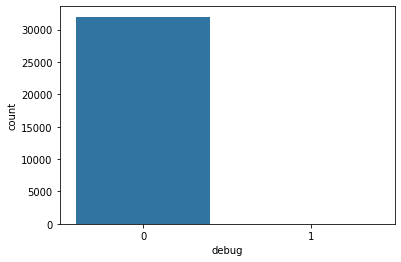

In [23]:
# how many rows having debug value
sns.countplot(x="debug", data=excel_data)

<AxesSubplot:xlabel='info', ylabel='count'>

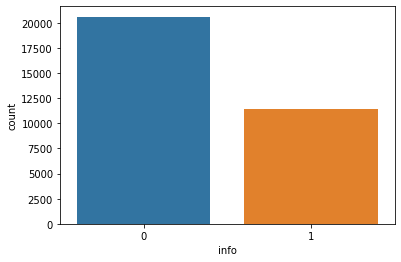

In [24]:
# how many rows having info value
sns.countplot(x="info", data=excel_data)

<AxesSubplot:xlabel='error', ylabel='count'>

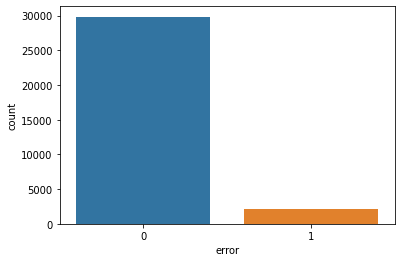

In [25]:
# how many rows having error value
sns.countplot(x="error", data=excel_data)

<AxesSubplot:xlabel='exception', ylabel='count'>

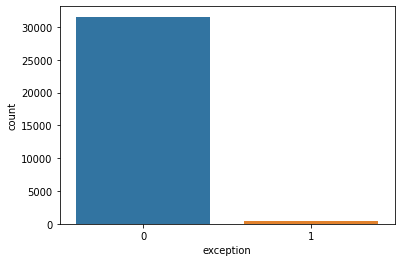

In [26]:
# how many rows having exception value
sns.countplot(x="exception", data=excel_data)

<AxesSubplot:xlabel='warn', ylabel='count'>

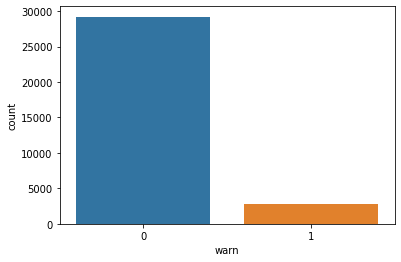

In [27]:
# how many rows having warn value
sns.countplot(x="warn", data=excel_data)

### Draw histogram 

<AxesSubplot:ylabel='Frequency'>

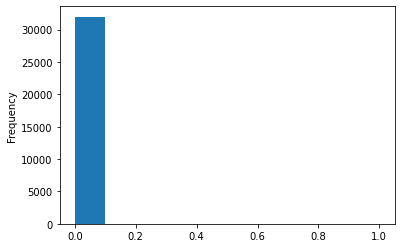

In [28]:
excel_data['debug'].plot.hist()


<AxesSubplot:ylabel='Frequency'>

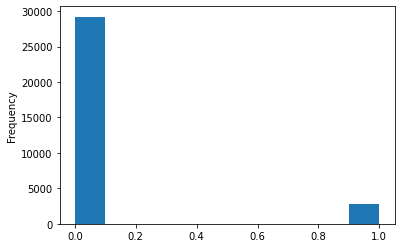

In [29]:
excel_data['warn'].plot.hist()

<AxesSubplot:ylabel='Frequency'>

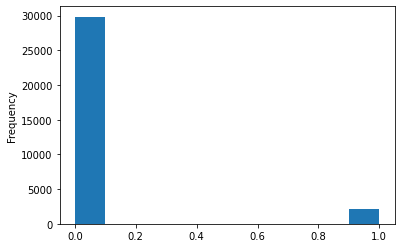

In [30]:
excel_data['error'].plot.hist()

<AxesSubplot:ylabel='Frequency'>

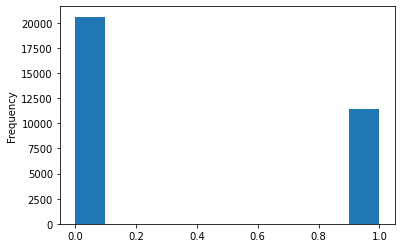

In [31]:
excel_data['info'].plot.hist()

<AxesSubplot:ylabel='Frequency'>

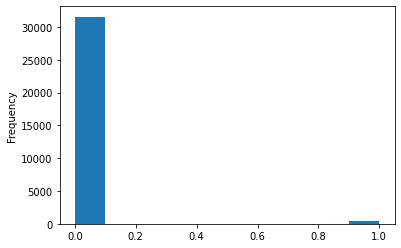

In [32]:
excel_data['exception'].plot.hist()

#  Data Wrangling


In [33]:
# Data Wrangling is to remove null or empty data, cleaning data set

In [34]:
print((excel_data.info()))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32000 entries, 0 to 31999
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   line       32000 non-null  object
 1   info       32000 non-null  int64 
 2   error      32000 non-null  int64 
 3   debug      32000 non-null  int64 
 4   warn       32000 non-null  int64 
 5   exception  32000 non-null  int64 
 6   filename   32000 non-null  object
dtypes: int64(5), object(2)
memory usage: 1.7+ MB
None


In [35]:
excel_data.isnull()


,line,info,error,debug,warn,exception,filename
0,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...
31995,False,False,False,False,False,False,False
31996,False,False,False,False,False,False,False
31997,False,False,False,False,False,False,False
31998,False,False,False,False,False,False,False


In [36]:
excel_data.isnull().sum()


line         0
info         0
error        0
debug        0
warn         0
exception    0
filename     0
dtype: int64

In [38]:
sns.heatmap(excel_data.isnull(), yticklabels==False)


NameError: name 'yticklabels' is not defined

<AxesSubplot:>

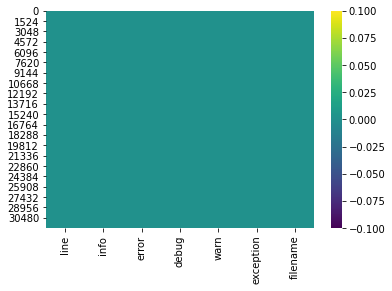

In [39]:
sns.heatmap(excel_data.isnull(), cmap="viridis")


<AxesSubplot:xlabel='error', ylabel='info'>

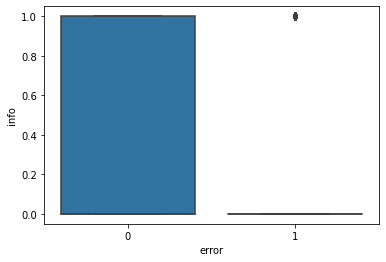

In [40]:
sns.boxplot(x="error", y="info", data=excel_data)


In [41]:
# either drop that row or fill some value where value is null
excel_data.head(5)
excel_data.isnull().sum()


line         0
info         0
error        0
debug        0
warn         0
exception    0
filename     0
dtype: int64

<AxesSubplot:>

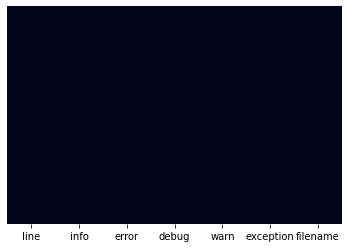

In [42]:
sns.heatmap(excel_data.isnull(), yticklabels=False, cbar=False)


<AxesSubplot:>

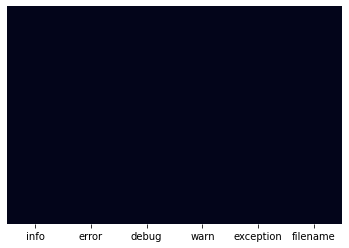

In [43]:
excel_data.drop("line", axis=1, inplace=True)
sns.heatmap(excel_data.isnull(), yticklabels=False, cbar=False)


In [44]:
excel_data.isnull().sum()


info         0
error        0
debug        0
warn         0
exception    0
filename     0
dtype: int64

### hold column values in variable


In [47]:
info=pd.get_dummies(excel_data['info'])

In [48]:
excel_data = pd.concat([excel_data, info], axis=1)
excel_data.head(5)


,info,error,debug,warn,exception,filename,0,1,0,1
0,0,0,0,0,0,HealthApp.log,1,0,1,0
1,0,0,0,0,0,HealthApp.log,1,0,1,0
2,0,0,0,0,0,HealthApp.log,1,0,1,0
3,0,0,0,0,0,HealthApp.log,1,0,1,0
4,0,0,0,0,0,HealthApp.log,1,0,1,0


In [49]:
excel_data.drop(['info'], axis=True, inplace=True)
excel_data.head(5)

,error,debug,warn,exception,filename,0,1,0,1
0,0,0,0,0,HealthApp.log,1,0,1,0
1,0,0,0,0,HealthApp.log,1,0,1,0
2,0,0,0,0,HealthApp.log,1,0,1,0
3,0,0,0,0,HealthApp.log,1,0,1,0
4,0,0,0,0,HealthApp.log,1,0,1,0


In [ ]:
excel_data.drop("f", axis=1, inplace=True)


#  Train and Test

In [50]:
X = excel_data.drop("error", axis=1)
y = excel_data["error"]

In [52]:
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

In [54]:
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression()

In [55]:
logmodel.fit(X_train, y_train)


ValueError: could not convert string to float: 'Hadoop.log'

In [ ]:
predictions = logmodel.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report
classification_report(y_test, predictions)


In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)


In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, predictions)


#  Collecting Data


# Accuracy Check
